In [20]:
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

from sklearn.datasets import make_regression, fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Gradient Boosting Regression
1. chain of models, where the successive models are trained on the *mistakes* of the preceding ones
2. begin with a mean-value model: mean of target value across all training samples = estimated value
    1. this mean value model will be called $\mathbf{F_0(x)}$
    2. calculate pseudoresiduals:
        1. for each sample in the training set, find PR = $y_i - \hat{y}_i$, and since $\hat{y}_i = \bar{y}$, 
            1. notice that the regression loss function, MSE, = $\sum\limits_{i=1}^N\dfrac{(y_i - \hat{y}_i)^2}{N}$, and $\nabla \mathcal{L} = -2\sum\limits_{i=1}^N\dfrac{(y_i - \hat{y}_i)}{N} = 2\sum\limits_{i=1}^N\dfrac{(\hat{y}_i - y_i)}{N}$
            2. notice the relation between the gradient of the loss function for a given sample, and the pseuoresidual of that sample.
            3. this is why, pseudoresidual is the negative gradient of MSE (regression loss function)
    3. use the pseudoresiduals as the **labels** that would be predicted by the successor model
3. usually DecisionTrees will be used as the weak learners after this mean-value model
4. a weak learner, i.e. a shallow decision tree , with small no. of nodes, is used:
    1. this is the first weak learner, i.e. $\mathbf{h_1(x)}$ and will now be fit on the original training data but using the PR's from the preceding model as the target.
    2. the predictions from this learner ($\mathbf{h_1(x)}$) will now be calculated.
    3. the prediction of the actual target variable at this stage, as given by the gradient boosting model built until now, will be $\mathbf{F_1(x)} = \mathbf{F_0(x)} + \eta\times\mathbf{h_1(x)}$, where $\eta$: learning rate hyperparameter.
    4. PR($F_1(x_i)$) = $y_i - F_1(x_i)$
    5. this will now serve as the target to train model 2, i.e. $h_2(x)$, upon which $\mathbf{F_2(x)} = \mathbf{F_0(x)} + \eta\times\mathbf{h_1(x)} + \eta\times\mathbf{h_2(x)} = F_1(x) + + \eta\times\mathbf{h_2(x)}$
    6. this is continued
    7. **Note:** that the samples in the nodes of these weak learners will have the pseudoresiduals from the previous learners within them, as opposed to the target variable y values that are generally stored in the nodes of a tree based algorithm/ensemble.
5. so after adding M models, $\mathcal{F}(x) = F_0(x) + \sum\limits_{m=1}^M \eta.h_m(x)$
6. **no bootstrapping, aggregation == boosting:**
7. **gradient** because the model gradually moves in the direction of the steepest descent w.r.t. the loss function, **boosting** due to the sequential combination of predictions from weak learners.
8. since there's no aggregation of uncorrelated learners, but rather an iterative learning procedure, boosting frameworks primarily focus on **lowering the bias, more than lowering the variance**, hence could tend to overfit more than bagging ensembles like Bagging models or Random Forest models.

## Mathematical intuition
- observe that for a perfect model with only 1 weak learner
    - the mean-value model will make some errors, which will be accurately predicted by the 1st weak learner
    - if learning rate = 1, $F_1(x) = y$ (think)
- if say the first weak learner wasn't perfect, but the 2nd learner was:
    - $F_2(x) = y$ (think)
- the basic idea behind the successive weak learner being trained using the residual of the previous weak learner is to minimize the eventual residual
    - observe that each new learner will theoretically take the residual as closer to 0 as it can.

## Why all underlying estimators are weak?
- to control overfitting, they are essentially *weak*
- either tree depth is constrained, or no. of leaf nodes. (Basically any sort of hyperparametric pre-pruning)
- each weak learner: computationally less expensive to train
- diversity: since the target is changing, different patterns are being learnt by each added weak learner.
- *weakness* is a form of regularizing DTs
- `subsample` in [`sklearn.GradientBoostingRegressor`](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) can be used to only use a random subset of samples to train the weak learners. <font color="red">Check if for each new weak learner does the sampling take place, or is it done once and then this subset is used for all weak learners!!</font>
- <font color="red">Why `freidman_mse` over `mse`?</font>

## Why learning rate?
- low learning rate: more no. of models added <font color="red">Test this!</font>
- smoothens the learning process
- just another method of reducing the risk of overfitting

## Convergence
- Hyperparameter based
    - `n_estimators`: once these many estimators are built, job done. allows till `inf`.
    - `warm_start = True`
    - `n_iter_no_change`: performs early stopping if validation score doesn't improve till for these many iterations. `validation_fraction` by default is `0.1`, so we already have a validation set within the model.
    - `tol`: tolerance for early stopping, the minimum improvement in validation score to constitute a change 

In [2]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=4, noise=0.2, random_state=42)

# Simulate some data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
gbr = GradientBoostingRegressor().fit(X_train, y_train)
rfr = RandomForestRegressor().fit(X_train, y_train)

# Residuals
residuals_gbr = y_test - gbr.predict(X_test)
residuals_rfr = y_test - rfr.predict(X_test)

# Correlation with residuals
residuals_df = pd.DataFrame({
    'Residual_GBR': residuals_gbr,
    'Residual_RFR': residuals_rfr,
    **{f'Feature_{i}': X_test[:, i] for i in range(X_test.shape[1])}
})

correlation_gbr = residuals_df.corr()['Residual_GBR'].sort_values(ascending=False)
correlation_rfr = residuals_df.corr()['Residual_RFR'].sort_values(ascending=False)

print("Top correlated features with GBR residuals:\n", correlation_gbr)
print("Top correlated features with RFR residuals:\n", correlation_rfr)


Top correlated features with GBR residuals:
 Residual_GBR    1.000000
Residual_RFR    0.853233
Feature_7       0.406423
Feature_8       0.387319
Feature_9       0.315151
Feature_1       0.282697
Feature_0       0.040919
Feature_6       0.026834
Feature_4       0.001473
Feature_3       0.000838
Feature_2      -0.031012
Feature_5      -0.049147
Name: Residual_GBR, dtype: float64
Top correlated features with RFR residuals:
 Residual_RFR    1.000000
Residual_GBR    0.853233
Feature_9       0.510706
Feature_8       0.485163
Feature_1       0.451374
Feature_7       0.298766
Feature_6       0.027480
Feature_0       0.023553
Feature_3       0.012446
Feature_4       0.010340
Feature_2      -0.007428
Feature_5      -0.068697
Name: Residual_RFR, dtype: float64


In [3]:
residuals_df

,Residual_GBR,Residual_RFR,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,8.811513,17.350903,-1.345014,-0.356092,0.109572,-0.861050,0.001977,1.532873,-0.416438,0.954085,1.218480,2.202014
1,-0.008523,10.085189,0.613518,2.142270,1.727543,-1.022793,0.038003,0.120031,0.436324,0.522835,-0.573700,-0.024355
2,-4.172355,-6.593240,-0.016423,-0.730930,-0.033127,1.188393,-0.517611,0.223788,1.794558,-0.176947,-0.798297,-1.379319
3,25.017706,30.552690,0.359739,2.824331,-1.318968,-0.498634,0.179622,1.345148,0.020106,2.497415,0.046006,-0.641114
4,-2.252838,9.395049,-0.454548,1.023531,0.175287,-0.218653,-0.411823,0.131928,-1.336725,1.695723,1.897289,0.156694
...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.768974,-0.001022,-1.715180,0.282036,-0.152855,0.825924,1.762980,-0.507717,0.433562,-0.879644,-0.820328,-0.223026
196,3.624788,5.315424,-0.527994,0.099314,-0.390409,1.353069,-0.652528,-0.611177,0.516144,-0.074345,-0.184551,0.592330
197,-2.056100,-1.272203,0.683329,-1.237662,0.869156,-0.209314,-0.763286,0.037938,0.887291,0.075955,0.742682,0.482249
198,1.985634,4.225181,-1.239562,0.258770,1.195531,-1.502871,0.504582,0.626538,-1.518970,0.135563,0.728519,0.637606


In [ ]:
import matplotlib.pyplot as plt

# Residuals vs predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gbr.predict(X_test), residuals_gbr, alpha=0.5, label='GBR Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predictions (GBR)')
plt.ylabel('Residuals')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(rfr.predict(X_test), residuals_rfr, alpha=0.5, label='RFR Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predictions (RFR)')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()


## Variation of model performance with learning rate

In [8]:
X, y = fetch_california_housing(return_X_y=True)
print(np.isnan(X).any())

False


In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train_scores, val_scores, lrs, n_estimator_arr = [], [], [], []
for lr in tqdm(np.linspace(0.1, 0.99, 20), "Processing different learning-rate based estimators..."):
    gbr = GradientBoostingRegressor(n_iter_no_change=5, learning_rate=lr).fit(x_train, y_train)
    n_estimator_arr.append(gbr.n_estimators_)
    train_scores.append(gbr.score(x_train, y_train))
    val_scores.append(gbr.score(x_test, y_test))
    lrs.append(lr)


Processing different learning-rate based estimators...:   0%|          | 0/20 [00:00<?, ?it/s]

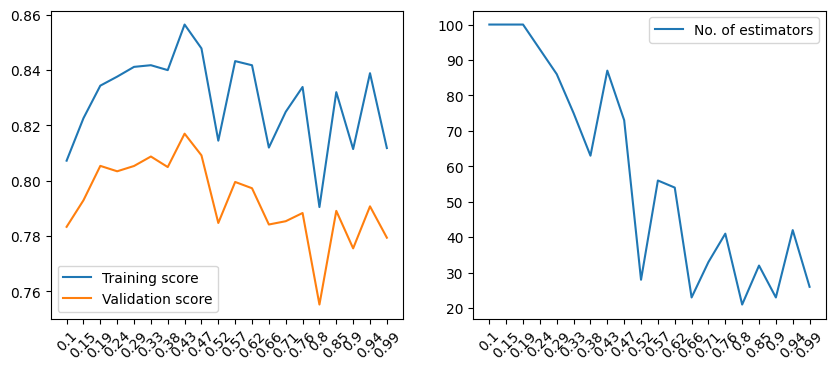

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(len(lrs)), train_scores, label='Training score')
ax[0].plot(range(len(lrs)), val_scores, label='Validation score')
ax[0].set_xticks(range(len(lrs)));ax[0].set_xticklabels(labels=[round(x, 2) for x in lrs], rotation=45)
ax[0].legend()

ax[1].plot(range(len(lrs)), n_estimator_arr, label='No. of estimators')
ax[1].set_xticks(range(len(lrs)));ax[1].set_xticklabels(labels=[round(x, 2) for x in lrs], rotation=45)
ax[1].legend()

plt.show()

# Classic Scenarios where GBM fails
- limited data, noisy data, too many unhandled outliers
- dataset drift, if no retraining pipeline established
- imbalanced data (without SMOTE)
- **datasets with too many features**: may not fail necessarily, but like tree algorithms take a lot of time to train the model
    - the **time could be wasted** in case of **too many redundant features**
- 

# Potentially failing scenarios
1. y = x1 XOR x2
2. y = sin(x1 + x2) - use maclaurin series (engineer features such as x1^2, x2^2, (x1+x2)^2....)

# Gradient Boosting Classifier - Binary Classification
1. current discussion limited to binary classification only.
2. labels = 0,1
3. base model $F_0(x) = log_e\left(\frac{p}{1-p}\right)$, known as log-odds. odds of positive class against the negative class
    1. $p$ is simply the ratio of no. of positive samples to the total no. of samples
4. hence, for base model, $p = \dfrac{1}{1+e^{-log\, odds}}$
5. pseudoresiduals, PR = $y_i - p$, which are technically numbers, hence the subsequent weak learners will be decision tree regressors
6. the nodes will hence store samples and their associated 
    1. **previous** learner's pseudoresiduals, **including the leafs**
    2. **previous** learner's **probabilities**, **including the leafs**
7. the log odds for this learner, lets call it $\Gamma_1$, is defined for each leaf node:
    1. $\Gamma_1 = \dfrac{\sum\limits_{\textrm{samples in this node}} \textrm{sum of previous learner's residuals} }{\sum\limits_{\textrm{samples in this node}} \textrm{previous learner's probability}\times(1-\textrm{previous learner's probability})}$
    2. Checkout [this blogpost](https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-2-classification-d3ed8f56541e) to know the derivation of the formula below:
8. At this stage, $F(x) = F_0(x) + \eta \times \Gamma_1$ where $\Gamma_1$ of that leaf node is used where the sample being predicted ends up in (as per the weak learner's decision path)
    1. The actual predictions at this stage: $p(x) = \dfrac{1}{1+e^{-F(x)}}$
9. This process is repeated iteratively till convergence.
10. <img src="gradientBoostingClassifier_demo1.png" /> <img src="gradientBoostingClassifier_demo2.png" />
11. sklearn's implementation handles the multi-class aspect which isn't addressed in the above theoretical explanation by creating as many regression trees as there as classes
    > In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.\
    HistGradientBoostingClassifier is a much faster variant of this algorithm for intermediate and large datasets (n_samples >= 10_000) and supports monotonic constraints.



## Intuition
1. Residuals simply denote the probability *left to compute*.
2. 

# Disadvantages
- memory complexity